In [2]:
%matplotlib inline
from bigbang.archive import Archive
import bigbang.analysis.entity_resolution
from bigbang.analysis import repo_loader
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import pylab
import numpy as np
import pandas as pd
from IPython.display import display  # Used to display widgets in the notebook
from IPython.display import clear_output

Introduction
============
In group efforts, there is sometimes the impression that there are those who work, and those who talk. A naive question to ask is whether or not the people that tend to talk a lot actually get any work done. This is an obviously and purposefully obtuse question with an interesting answer.

We can use BigBang's newest feature, git data collection, to compare all of the contributors to a project, in this case Scipy, based on their email and git commit activity. The hypothesis in this case was that people who commit a lot will also tend to email a lot, and vice versa, since their involvement in a project would usually require them to do both. This hypothesis was proven to be correct. However, the data reveals many more interesting phenomenon.

In [4]:
# Load the raw email and git data
url = "http://mail.python.org/pipermail/scipy-dev/"
arx = Archive(url, archive_dir="../archives")
mailInfo = arx.data
repo = repo_loader.get_repo("bigbang")
gitInfo = repo.commit_data;

Checking for bigbang at /home/aryan/urap/bigbang/archives/sample_git_repos/bigbang
failed to add a commit because of an encoding error
failed to add a commit because of an encoding error


Entity Resolution
=================
Git and Email data comes from two different datatables. To observe a single person's git and email data, we need a way to identify that person across the two different datatables. 

To solve this problem, I wrote an entity resolution client that will parse a Pandas dataframe and add a new column to it called "Person-ID" which gives each row an ID that represents one unique contributor. A person may go by many names ("Robert Smith, Rob B. Smith, Bob S., etc.) and use many different emails. However, this client will read through these data tables in one pass and consolidate these identities based on a few strategies. 

In [5]:
entityResolve = bigbang.entity_resolution.entityResolve
mailAct = mailInfo.apply(entityResolve, axis=1, args=("From", None))
gitAct = gitInfo.apply(
    entityResolve, axis=1, args=("Committer Email", "Committer Name")
)

After we've run entity resolution on our dataframes, we split the dataframe into slices based on time. So for the entire life-span of the project, we will have NUM_SLICES different segments to analyze. We will be able to look at the git and email data up until that certain date, which can let us analyze these changes over time.

In [6]:
NUM_SLICES = 1500  # Number of animation frames. More means more loading time

In [7]:
mailAct.sort("Date")
gitAct.sort("Time")


def getSlices(df, numSlices):
    sliceSize = len(df) / numSlices
    slices = []
    for i in range(1, numSlices + 1):
        start = 0
        next = (i) * sliceSize
        next = min(next, len(df) - 1)  # make sure we don't go out of bounds

        slice = df.iloc[start:next]
        slices.append(slice)
    return slices


mailSlices = getSlices(mailAct, NUM_SLICES)
gitSlices = getSlices(gitAct, NUM_SLICES)

Merging Data Tables
===================
Now we want to merge these two tables based on their Person-ID values. Basically, we first count how many emails / commits a certain contributor had in a certain slice. We then join all the rows with the same Person-ID to each other, so that we have the number of emails and the number of commits of each person in one row per person in one consolidated dataframe. We then delete all the rows where both of these values aren't defined. These represent people for whom we have git data but not mail data, or vice versa.

In [8]:
def processSlices(slices):
    for i in range(len(slices)):
        slice = slices[i]
        slice = slice.groupby("Person-ID").size()
        slice.sort()
        slices[i] = slice


def concatSlices(slicesA, slicesB):
    # assumes they have the same number of slices
    # First is emails, second is commits
    ansSlices = []
    for i in range(len(slicesA)):
        sliceA = slicesA[i]
        sliceB = slicesB[i]
        ans = pd.concat({"Emails": sliceA, "Commits": sliceB}, axis=1)
        ans = ans[pd.notnull(ans["Emails"])]
        ans = ans[pd.notnull(ans["Commits"])]
        ansSlices.append(ans)
    return ansSlices


processSlices(mailSlices)
processSlices(gitSlices)

finalSlices = concatSlices(mailSlices, gitSlices)

Coloring
========
We now assign a float value [0 --> 1] to each person. This isn't neccesary, but can let us graph these changes in a scatter plot and give each contributor a unique color to differentiate them. This will help us track an individual as their dot travels over time. 

In [9]:
def idToFloat(id):
    return id * 1.0 / 400.0


for i in range(len(finalSlices)):
    slice = finalSlices[i]
    toSet = []

    for i in slice.index.values:
        i = idToFloat(i)
        toSet.append(i)
    slice["color"] = toSet

Here we graph our data. Each dot represents a unique contributor's number of emails and commits. As you'll notice, the graph is on a log-log scale.

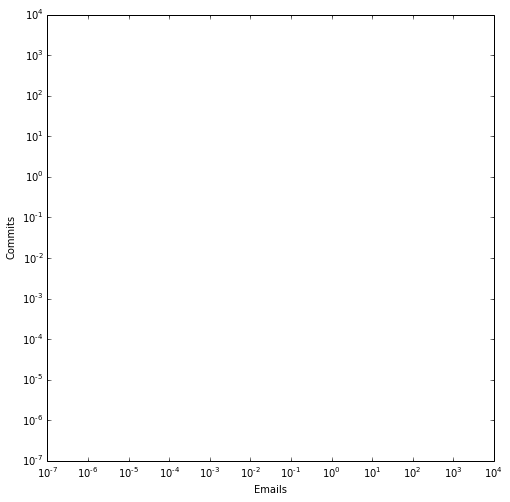

In [10]:
data = finalSlices[len(finalSlices) - 1]  # Will break if there are 0 slices
fig = plt.figure(figsize=(8, 8))

d = data
x = d["Emails"]
y = d["Commits"]
c = d["color"]
ax = plt.axes(xscale="log", yscale="log")


plt.scatter(x, y, c=c, s=75)
plt.ylim(0, 10000)
plt.xlim(0, 10000)
ax.set_xlabel("Emails")
ax.set_ylabel("Commits")
plt.plot([0, 1000], [0, 1000], linewidth=5)

plt.show()

Animations
==========
Below this point, you'll find the code for generating animations. This can take a long time (~30 mins) for a large number of slices. However, the pre-generated videos are below.

The first video just shows all the contributors over time without unique colors. The second video has a color for each contributor, but also contains a Matplotlib bug where the minimum x and y values for the axes is not followed. 

There is a lot to observe. As to our hypothesis, it's clear that people who email more commit more. In our static graph, we could see many contributors on the x-axis -- people who only email -- but this dynamic graph allows us to see the truth. While it may seem that they're people who only email, the video shows that even these contributors eventually start committing. Most committers don't really get past 10 commits without starting to email the rest of the project, for pretty clear reasons. However, the emailers can "get away with" exclusively emailing for longer, but eventually they too start to commit. In general, not only is there a positive correlation, there's a general trend of everyone edging close to having a stable and relatively equal ratio of commits to emails.

In [ ]:
from IPython.display import YouTubeVideo

display(YouTubeVideo("GCcYJBq1Bcc", width=500, height=500))
display(YouTubeVideo("uP-z4jJqxmI", width=500, height=500))

In [ ]:
fig = plt.figure(figsize=(8, 8))
a = finalSlices[0]

print(type(plt))
ax = plt.axes(xscale="log", yscale="log")
(graph,) = ax.plot(x, y, "o", c="red", alpha=1, markeredgecolor="none")
ax.set_xlabel("Emails")
ax.set_ylabel("Commits")
plt.ylim(0, 10000)
plt.xlim(0, 10000)


def init():
    graph.set_data([], [])
    return (graph,)


def animate(i):
    a = finalSlices[i]
    x = a["Emails"]
    y = a["Commits"]
    graph.set_data(x, y)
    return (graph,)


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=NUM_SLICES, interval=1, blit=True
)

anim.save("t1.mp4", fps=15)

In [ ]:
def main():
    data = finalSlices
    first = finalSlices[0]
    fig = plt.figure(figsize=(8, 8))

    d = data
    x = d[0]["Emails"]
    y = d[0]["Commits"]
    c = d[0]["color"]

    ax = plt.axes(xscale="log", yscale="log")
    scat = plt.scatter(x, y, c=c, s=100)
    plt.ylim(0, 10000)
    plt.xlim(0, 10000)
    plt.xscale("log")
    plt.yscale("log")
    ani = animation.FuncAnimation(
        fig, update_plot, frames=NUM_SLICES, fargs=(data, scat), blit=True
    )
    ani.save("test.mp4", fps=10)
    # plt.show()


def update_plot(i, d, scat):
    x = d[i]["Emails"]
    y = d[i]["Commits"]
    c = d[i]["color"]
    plt.cla()
    ax = plt.axes()
    ax.set_xscale("log")
    ax.set_yscale("log")

    scat = plt.scatter(x, y, c=c, s=100)

    plt.ylim(0, 10000)
    plt.xlim(0, 10000)
    plt.xlabel("Emails")
    plt.ylabel("Commits")
    return (scat,)


main()